# Проект по дисциплине "анализ сетевых данных"

Задача: Имеется набор пунктов выдачи заказов в городе. Требуется найти путь проходящий через все пункты из списка за кратчайшее время в пути (на автомобиле)

In [1]:
! pip3 install -r requirements.txt

In [2]:
from link_parser import parse_links
from info_parser import parse_info
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from shapely import Point
from pyproj import CRS
import geopandas as gpd
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
import warnings
import math
import ast

ox.settings.use_cache = True
ox.settings.log_console = False
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
def convert_wgs_to_utm(lon: float, lat: float):
    """Based on lat and lng, return best utm epsg-code"""
    
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
        return epsg_code
    epsg_code = '327' + utm_band
    
    return epsg_code

point = Point((47.247728, 56.139918))  # координаты города Чебоксары
init_crs='epsg:4326' 
init_crs = CRS.from_string(init_crs)
crs_str = 'epsg:' + convert_wgs_to_utm(lon=point.x, lat = point.y)
crs_fin = CRS.from_user_input(crs_str)

def get_utm_df(
        df,
        init_crs = init_crs, 
        crs_fin = crs_fin,
        wkt_geometry_column = None
    ):
    
    df_utm = []
    if wkt_geometry_column is None:
        df_utm = gpd.GeoDataFrame(df, geometry=df['geometry'])
    else:
        df_utm = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df[wkt_geometry_column]))
        # df_utm.drop(columns=wkt_geometry_column, inplace=True)
    df_utm = df_utm.set_crs(init_crs)
    df_utm = df_utm.to_crs(crs_fin)
    
    return df_utm

def preprocess_parse_result(df):
    df = df[['ID', 'name', 'coordinates']]
    df['coordinates'] = df['coordinates'].apply(ast.literal_eval)
    df = df[df['coordinates'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
    df['lon'] = df['coordinates'].apply(lambda x: x[0])
    df['lat'] = df['coordinates'].apply(lambda x: x[1])
    df['geometry'] = df['coordinates'].apply(lambda x: Point(x))
    df.drop(columns='coordinates', inplace=True)
    df_utm = get_utm_df(df)
    
    return df_utm

def plot_roads_graph(G, df, gdf):
    # визуализация графа с целевыми точками
    all_nodes = list(G.nodes())
    target_nodes = df['node'].to_list()
    target_ids = df['ID'].to_list()
    target_ids_dict = dict(zip(target_nodes, target_ids))

    node_colour = ['y' if node in target_nodes else 'deepskyblue' for node in all_nodes]
    node_size = [35 if node in target_nodes else 8 for node in all_nodes]
    node_alpha = [1. if node in target_nodes else 0.4 for node in all_nodes]

    # здания
    fig, ax = ox.plot_footprints(gdf, figsize=(15, 15), alpha=0.5, show=False, close=False, color='r')

    # граф дорог
    fig, ax = ox.plot_graph(
        G, 
        ax=ax,
        node_size=node_size, 
        node_color=node_colour,
        node_alpha=node_alpha,
        edge_color='deepskyblue',
        edge_alpha=0.4,
        edge_linewidth=0.9,
        show=False, 
        close=False
        )

    # ID объектов
    for node_num, node in ox.graph_to_gdfs(G, edges=False).fillna("").iterrows():
        if node_num in target_ids_dict:
            text = str(target_ids_dict[node_num])
            ax.annotate(text, (node.x-2e-3, node.y+1.2e-3), c="y",)
    plt.show()
    
def plot_routes_on_roads_graph(G, df, gdf, routes):
    # визуализация графа с целевыми точками
    all_nodes = list(G.nodes())
    target_nodes = df['node'].to_list()
    target_ids = df['ID'].to_list()
    target_ids_dict = dict(zip(target_nodes, target_ids))

    node_colour = ['y' if node in target_nodes else 'deepskyblue' for node in all_nodes]
    node_size = [35 if node in target_nodes else 8 for node in all_nodes]
    node_alpha = [1. if node in target_nodes else 0.4 for node in all_nodes]

    # здания
    fig, ax = ox.plot_footprints(gdf, figsize=(15, 15), alpha=0.5, color='r', show=False, close=False)

    fig, ax = ox.plot_graph_routes(G, routes, ax=ax, route_colors='limegreen', show=False, close=False)
    
    # граф дорог
    fig, ax = ox.plot_graph(
        G, 
        ax=ax,
        node_size=node_size, 
        node_color=node_colour,
        node_alpha=node_alpha,
        edge_color='deepskyblue',
        edge_alpha=0.4,
        edge_linewidth=0.9,
        show=False, 
        close=False
        )

    # ID объектов
    for node_num, node in ox.graph_to_gdfs(G, edges=False).fillna("").iterrows():
        if node_num in target_ids_dict:
            text = str(target_ids_dict[node_num])
            ax.annotate(text, (node.x-2e-3, node.y+1.2e-3), c="y",)
            
    # порядок посещения точек
    order_num = 0
    node_num = routes[0][0]
    text = str(order_num)
    x = G.nodes[node_num]["x"]
    y = G.nodes[node_num]["y"]
    ax.annotate(text, (x-3.3e-3, y-2.5e-3), weight='bold', c="lime",)
    order_num += 1
    for route in routes:
        node_num = route[-1]
        text = str(order_num)
        x = G.nodes[node_num]["x"]
        y = G.nodes[node_num]["y"]
        ax.annotate(text, (x-3.3e-3, y-2.5e-3), weight='bold', c="lime",)
        order_num += 1
          
    plt.show()

def get_rout_time(route, G):
    route_time = int(sum(ox.utils_graph.route_to_gdf(G, route, "travel_time")["travel_time"]))
    
    return route_time

def get_route_length(route, G):
    route_length = int(sum(ox.utils_graph.route_to_gdf(G, route, "length")["length"]))
    
    return route_length

def choose_shortest(routes, G):
    route_times = [get_rout_time(route, G) for route in routes]
    route_num = np.argmin(route_times)
    
    return routes[route_num]

def find_n_nearest(point_id, df, n):
    point = df[df['ID'] == point_id]['geometry']
    distances_df = df[df['ID'] != point_id][['ID', 'geometry']]
    distances_df['distance'] = distances_df['geometry'].apply(lambda x: x.distance(point))
    distances_df.sort_values(by='distance', inplace=True)
    nearest_n_point_ids = distances_df.iloc[:n, :]['ID'].to_list()
    
    return nearest_n_point_ids

def find_full_path(first_point_id, points_ids, df, G, n=4):
    nodes = df['node'].to_list()
    ids = df['ID'].to_list()
    nodes_to_ids_dict = dict(zip(nodes, ids))
    ids_to_nodes_dict = dict(zip(ids, nodes))
    
    result_routes = []
    with tqdm(desc= f'routing', total=len(points_ids)-1) as pbar:
        for _ in range(len(points_ids)-1):
            df_loc = df[df['ID'].isin(points_ids+[first_point_id])].reset_index(drop=True)
            
            if first_point_id in points_ids:
                points_ids.remove(first_point_id)
            
            # чтобы не искать кратчайший путь по графу среди всех целевых узлов
            # выбираю n ближайших и ищу кратчайший среди них
            n_nearest_points_ids = find_n_nearest(first_point_id, df_loc, n=n)
            orig = ids_to_nodes_dict[first_point_id]
            dests = [ids_to_nodes_dict[point_id] for point_id in n_nearest_points_ids]
            # ищу кратчайшие пути по графу до отобранных n ближайших
            routes = []
            for dest in dests:
                route = ox.shortest_path(G, orig, dest, weight="travel_time")
                routes.append(route)
            # среди них беру кратчайший —> след пункт назначения выбран
            next_route = choose_shortest(routes, G)
            result_routes.append(next_route)
            pbar.update(1)
            pbar.refresh()
            first_point_id = nodes_to_ids_dict[next_route[-1]]
    
    return result_routes

## Парсинг пунктов выдачи

In [13]:
CITY = 'Чебоксары'
TYPE_ORG = 'delivery_point'
DELIVERY_POINT_DATA = './result_output/Чебоксары/delivery_point_outputs.csv'

In [4]:
parse_links(type_org=TYPE_ORG, city=CITY)

[WDM] - Downloading: 100%|██████████| 1.85M/1.85M [00:00<00:00, 10.7MB/s]


Чебоксары delivery_point, links parsing: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [5]:
parse_info(type_org=TYPE_ORG, city=CITY)

Чебоксары delivery_point, info parsing:   0%|          | 0/75 [00:00<?, ?it/s]

In [14]:
delivery_point_raw_df = pd.read_csv(DELIVERY_POINT_DATA, delimiter='\t')
delivery_point_raw_df.head(2)

,ID,city,category,name,address,coordinates,website,opening_hours,ypage,rating,n_reviews,phone,social,stops,tags
0,1,Чебоксары,Пункты выдачи,Ozon,"просп. Тракторостроителей, 39Б, Чебоксары","[47.303359, 56.101941]",www.ozon.ru,"'mon': 08:00-20:00, 'tue': 08:00-20:00, 'wed':...",https://yandex.ru/maps/org/ozon/7663687185/?ll...,"4,3",3 отзыва,+7(495)232-10-00,"https://ok.ru/ozon, https://t.me/ozonru, https...",остановка Школа № 56 (252 м)\nостановка Больни...,Пункт выдачи
1,2,Чебоксары,Пункты выдачи,Ozon,"Ярмарочная ул., 15, Чебоксары","[47.264497, 56.132994]",www.ozon.ru,"'mon': 09:00-21:00, 'tue': 09:00-21:00, 'wed':...",https://yandex.ru/maps/org/ozon/238954048617/?...,"4,5",11 отзывов,+7(495)232-10-00,"https://ok.ru/ozon, https://t.me/ozonru, https...",остановка Гостиница Россия (720 м)\nостановка ...,Пункт выдачи


In [15]:
delivery_point_df = preprocess_parse_result(delivery_point_raw_df)
delivery_point_df.head()

/var/folders/qs/y8j1xfxj3gsgry0y703t97jr0000gn/T/ipykernel_19061/2265525184.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coordinates'] = df['coordinates'].apply(ast.literal_eval)


,ID,name,lon,lat,geometry
0,1,Ozon,47.303359,56.101941,POINT (643262.534 6219816.172)
1,2,Ozon,47.264497,56.132994,POINT (640732.477 6223191.332)
2,3,Ozon,47.197937,56.119831,POINT (636643.402 6221592.907)
3,4,Ozon,47.219143,56.152048,POINT (637846.162 6225219.834)
4,5,Лабиринт,47.251252,56.124713,POINT (639939.572 6222242.986)


## Граф дорог

In [17]:
PLACE = "Cheboksary, Russia"

In [18]:
# выгрузка графа автомобильных дорог
G = ox.graph_from_place(PLACE, network_type="drive")

# добавление скоростей к ребрам и расчет времени в пути по каждому ребру
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

# здания
gdf = ox.features_from_place(PLACE, {"building": True})

# привязка объектов к ближайшим узлам графа
delivery_point_df['node'] = delivery_point_df[['lon', 'lat']].apply(
    lambda x: ox.distance.nearest_nodes(G, X=x[0], Y=x[1]),
    axis=1
)

/var/folders/qs/y8j1xfxj3gsgry0y703t97jr0000gn/T/ipykernel_19061/542340924.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: ox.distance.nearest_nodes(G, X=x[0], Y=x[1]),
/var/folders/qs/y8j1xfxj3gsgry0y703t97jr0000gn/T/ipykernel_19061/542340924.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: ox.distance.nearest_nodes(G, X=x[0], Y=x[1]),
/var/folders/qs/y8j1xfxj3gsgry0y703t97jr0000gn/T/ipykernel_19061/542340924.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

In [19]:
# исключить дубликаты по узлам
# т.к. несколько объектов могут привязываться к одному и тому же узлу
delivery_point_df = delivery_point_df.drop(columns=['ID']).drop_duplicates(subset=['node'])
delivery_point_df = delivery_point_df.reset_index(drop=True).reset_index().rename(columns={'index': 'ID'})

In [20]:
delivery_point_df.tail()

,ID,name,lon,lat,geometry,node
54,54,Ozon,47.225187,56.130827,POINT (638297.714 6222870.712),4137736457
55,55,Wildberries,47.183393,56.111254,POINT (635769.589 6220609.844),694362160
56,56,Wildberries,47.278833,56.096535,POINT (641757.257 6219164.022),1221346306
57,57,Ozon,47.229773,56.146555,POINT (638526.102 6224629.937),1460406158
58,58,Wildberries,47.171017,56.144409,POINT (634884.036 6224274.697),679904932


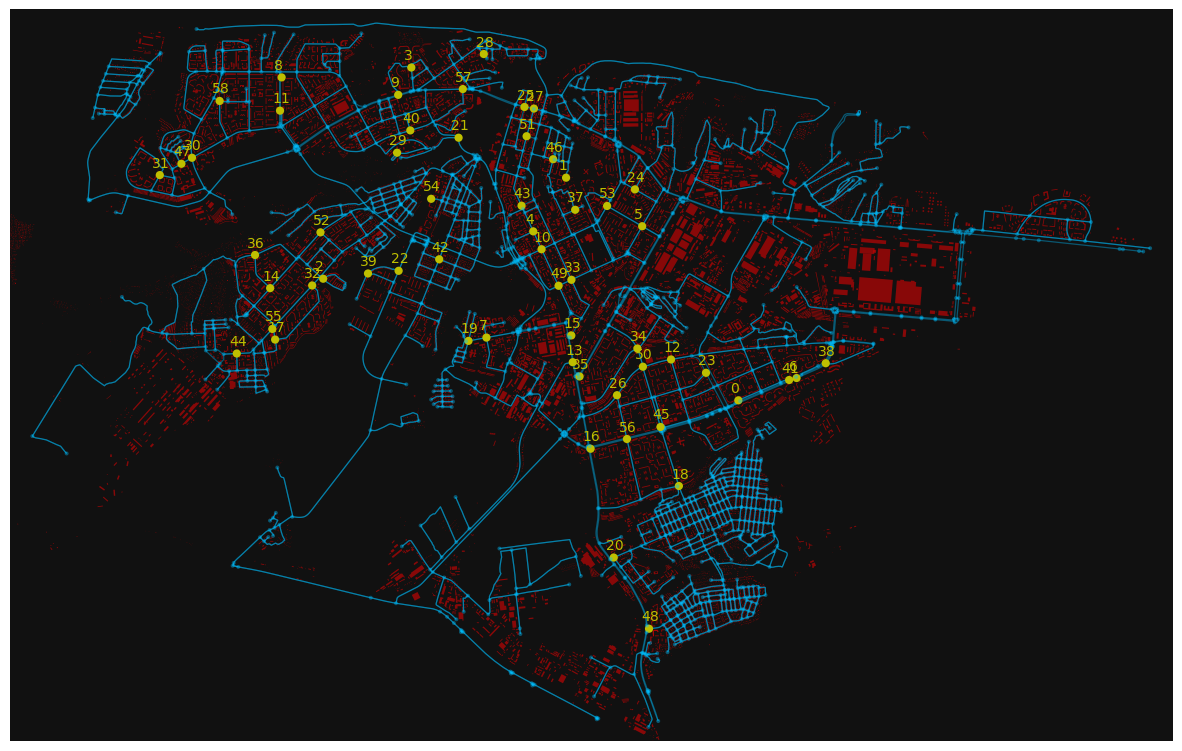

In [21]:
# визуализация графа с целевыми точками
plot_roads_graph(G, delivery_point_df, gdf)

## Поиск кратчайшего (по времени) пути

In [56]:
first_point_id = 18
points_ids = list(range(len(delivery_point_df)))

In [57]:
len(delivery_point_df)

59

In [73]:
routes = find_full_path(first_point_id, points_ids.copy(), delivery_point_df, G, n=4)

/Users/ftn/anaconda3/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


routing:   0%|          | 0/58 [00:00<?, ?it/s]

In [74]:
sum_time = 0 # seconds
for route in routes:
    sum_time += get_rout_time(route, G)
print('travel time:', np.around(sum_time/60., 2), 'min')

travel time: 137.12 min


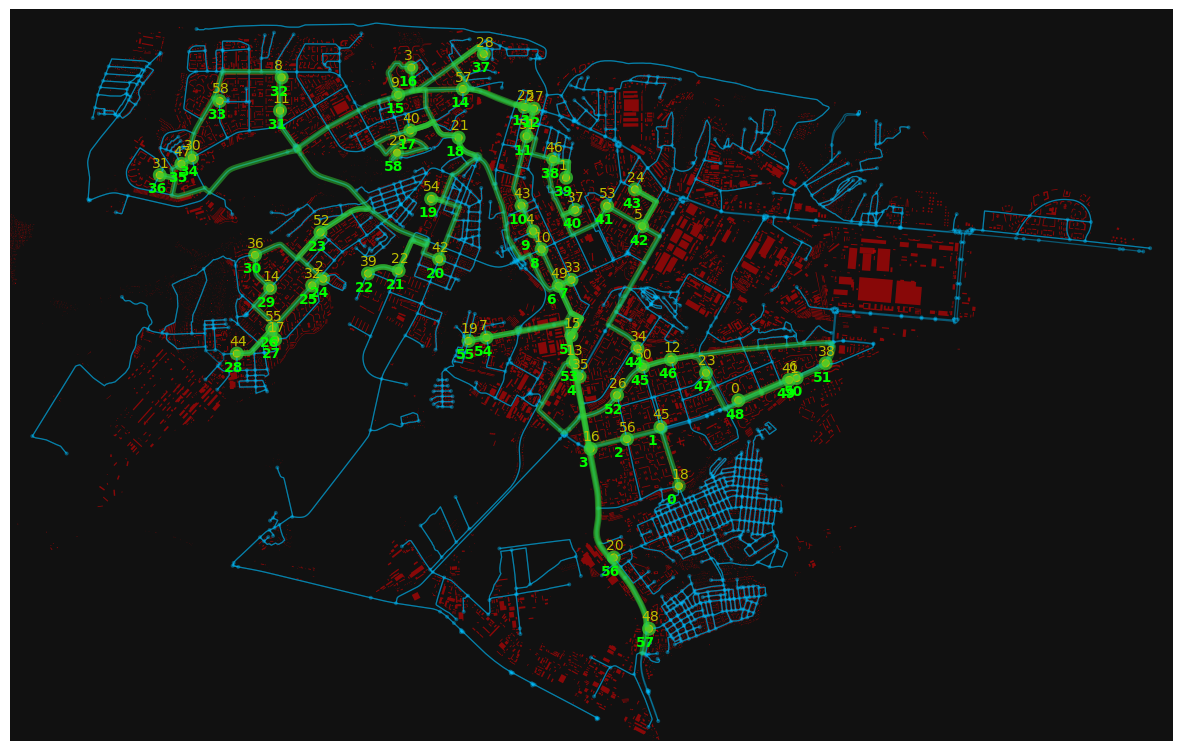

In [68]:
plot_routes_on_roads_graph(G, delivery_point_df, gdf, routes)

### Результаты

| n | время в пути | время работы алгоритма |
| - | ------------ | ---------------------- |
| 1 | 144.7 min | 0.7 s |
| 2 | 144.93 min | 1.1 s |
| 3 | 139.68 min | 1.4 s |
| 4 | 137.12 min | 1.7 s |
| 5 | 137.12 min | 1.9 s |
| 59 | 137.12 min | 10.9 s |

### Вывод 
В данном случае аппроксимации с n=4 достаточно, чтобы найти оптимальный маршрут по всем 59 пунктам.

### Что можно улучшить?
- Нанесение пунктов на граф методом проекции на ребра
- Учет пробок
- Оптимизация алгоритма поиска ближайших точек к заданной
- Масштабирование на все регионы